# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        # Вихідний шар
        self.out = DenseLayer(n_hidden_2, num_classes)


    def __call__(self, x):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out(x, activation=1)  # softmax на виході
        return x

In [6]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
      pred = neural_net(input_x)
      loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)
    # Модифікуємо параметри (оновлення вагів)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [8]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі (навчання на батчі)
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"step: {step}, loss: {loss:.4f}, accuracy: {acc:.4f}")


step: 100, loss: 286.5890, accuracy: 0.7070
step: 200, loss: 223.4641, accuracy: 0.7617
step: 300, loss: 192.3740, accuracy: 0.8047
step: 400, loss: 123.5665, accuracy: 0.8555
step: 500, loss: 107.1987, accuracy: 0.8867
step: 600, loss: 134.2062, accuracy: 0.8164
step: 700, loss: 96.7798, accuracy: 0.8828
step: 800, loss: 107.4960, accuracy: 0.8594
step: 900, loss: 103.2744, accuracy: 0.8945
step: 1000, loss: 115.8632, accuracy: 0.8477
step: 1100, loss: 81.6043, accuracy: 0.8945
step: 1200, loss: 73.5185, accuracy: 0.8984
step: 1300, loss: 84.9952, accuracy: 0.9023
step: 1400, loss: 72.4100, accuracy: 0.9062
step: 1500, loss: 92.1242, accuracy: 0.8984
step: 1600, loss: 50.4393, accuracy: 0.9336
step: 1700, loss: 77.6528, accuracy: 0.8906
step: 1800, loss: 80.6911, accuracy: 0.9102
step: 1900, loss: 60.5801, accuracy: 0.9297
step: 2000, loss: 90.5501, accuracy: 0.8906
step: 2100, loss: 74.9320, accuracy: 0.9375
step: 2200, loss: 84.6355, accuracy: 0.9023
step: 2300, loss: 95.4600, accur

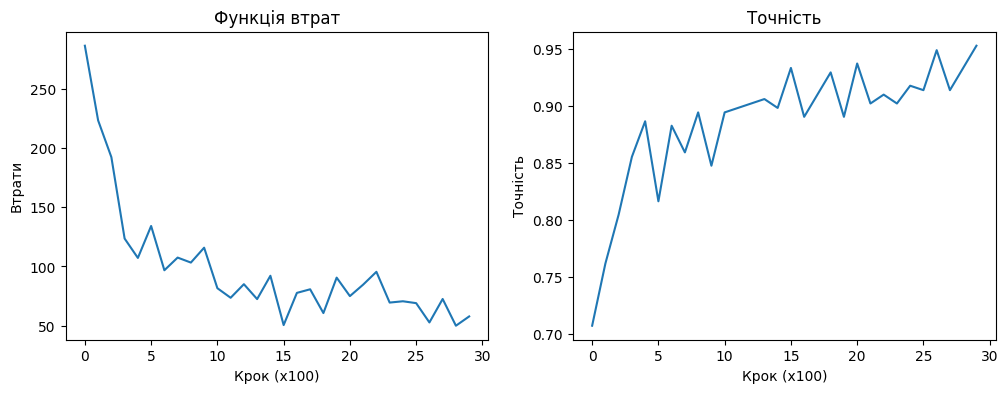

In [10]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Виведіть графік функції втрат
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_history)), loss_history)
plt.title('Функція втрат')
plt.xlabel('Крок (x100)')
plt.ylabel('Втрати')

# Виведіть графік точності
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracy_history)), accuracy_history)
plt.title('Точність')
plt.xlabel('Крок (x100)')
plt.ylabel('Точність')
plt.show()


In [12]:
from sklearn.metrics import classification_report

# Обчисліть точність навченої нейромережі
test_pred = neural_net(x_test)
test_accuracy = accuracy(test_pred, y_test)
print(f"\nТочність на тестових даних: {test_accuracy:.4f}")
# Тестування моделі на тестових даних
y_pred = tf.argmax(test_pred, 1).numpy()
print("\nЗвіт про класифікацію:")
print(classification_report(y_test, y_pred))


Точність на тестових даних: 0.8995

Звіт про класифікацію:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       980
           1       0.98      0.97      0.97      1135
           2       0.88      0.87      0.87      1032
           3       0.84      0.89      0.87      1010
           4       0.90      0.91      0.90       982
           5       0.88      0.84      0.86       892
           6       0.92      0.93      0.92       958
           7       0.92      0.90      0.91      1028
           8       0.84      0.86      0.85       974
           9       0.90      0.86      0.88      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



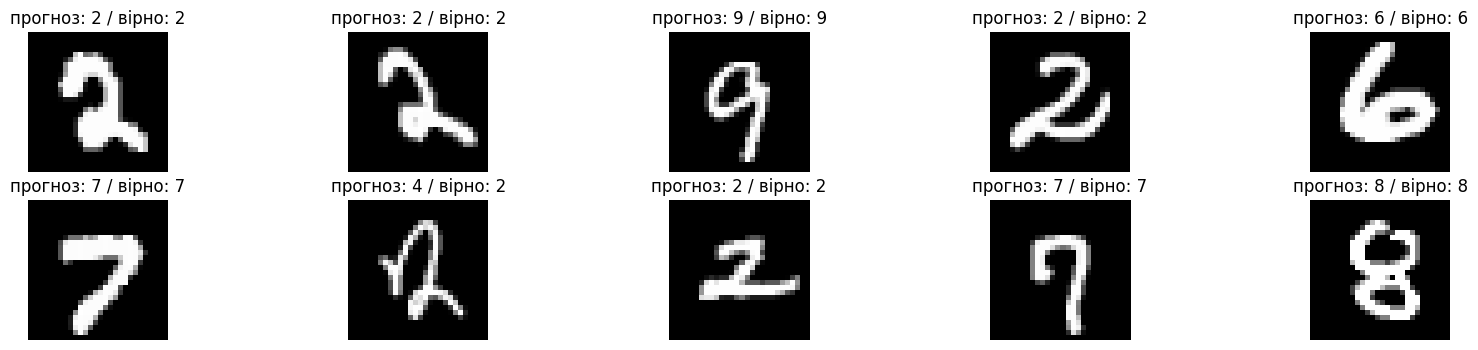

In [17]:
# Протестуйте навчену нейромережу на 10 зображеннях.
# З тестової вибірки візьміть 5 випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
plt.figure(figsize=(20, 4))
for i in range(10):
    idx = random.randint(0, len(x_test)-1)
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    pred = neural_net(x_test[idx:idx+1])
    predicted_label = tf.argmax(pred, 1).numpy()[0]
    true_label = y_test[idx]
    plt.title(f'прогноз: {predicted_label} / вірно: {true_label}')
    plt.axis('off')
plt.show()


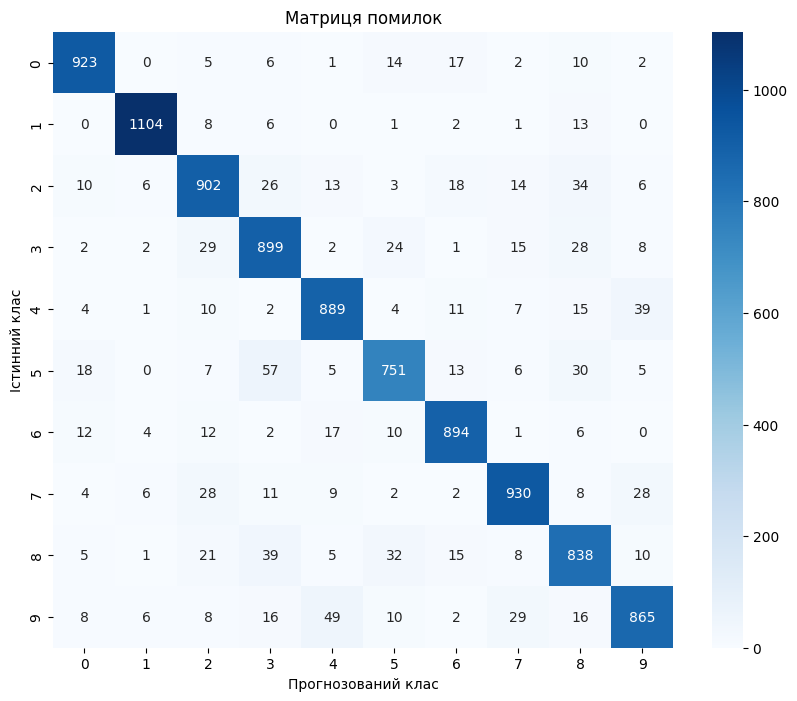

In [18]:
# Матриці помилок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Матриця помилок')
plt.xlabel('Прогнозований клас')
plt.ylabel('Істинний клас')
plt.show()

In [ ]:

# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?


Мережа правильно класифікує приблизно 89.95% зразків, а отже, помиляється в середньому у 10.05% випадків.

Мережа краще класифікує класи «1», «0» і «6», де precision та recall перевищують 0.92, що означає меншу ймовірність помилок у цих класах. Однак для класів «3», «5» і «8» precision і recall дещо нижчі, що вказує на більшу ймовірність помилок саме в цих класах.

Таким чином, основні помилки трапляються в складніших для мережі класах, таких як «3», «5» і «8»